# Índice
1. [Introdução](#introduction)   
2. [Pré-processamento](#preprocessamento)
3. [Lasso](#lasso)    
    3.1. [Lasso - Winter Weather Dataset ](#winter)   
    3.2. [Lasso - Summer Weather Dataset](#summer)    
    3.3. [Lasso - Spring Weather Dataset ](#spring)   
    3.4. [Lasso - Autumn Weather Dataset ](#autumn)   
4. [Métricas para avaliar os resultados previstos](#metrics)    
    4.1. [Mean Absolute Error](#mae)   
    4.2. [Root Mean Square Error](#rmse) 
5. [Referências](#references)    
***

## 1. Introdução <a name="introduction"></a>   
<p style="text-align: justify">Seguindo a orientação do "scikit-learn algorithm cheat-sheet", fornecido pelo <i>scikit-learn</i>, o <i>dataset</i> utilizado possui menos de 100k de amostras, e algumas <i>features</i> serão importantes para o modelo.   
Dois algoritmos podem ser utilizados: <i>Lasso</i> e <i>ElasticNet</i>.</p>     

![Choosing the right estimator](http://scikit-learn.org/stable/_static/ml_map.png)    


<p>Este <i>notebook</i> contém a utilização do algoritmo de regressão, <b>Lasso</b>, para prever a temperatura mínima em diferentes estações.</p>

## 2. Pré processamento dos dados <a name="preprocessamento"></a>

<p>O pré processamento, que foi detalhado em outro <i>notebook</i>, contém todo o tratamento do dataset, para a aplicação dos algoritmos.</p>

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

# As colunas estão separadas pelo símbolo ';' #. 
weather_history = pd.read_csv('rdu-weather-history.csv', sep=';')

In [2]:
# Substituindo as string por números binários -- No = 0 e Yes = 1

weather_history = weather_history.replace('No', 0.0)
weather_history = weather_history.replace('Yes', 1.0)

In [3]:
# Verificando a soma dos valores nulos em cada feature

weather_history.isnull().sum()

date                     0
temperaturemin           1
temperaturemax           1
precipitation            1
snowfall                 2
snowdepth                1
avgwindspeed             3
fastest2minwinddir       2
fastest2minwindspeed     2
fastest5secwinddir      19
fastest5secwindspeed    19
fog                      0
fogheavy                 0
mist                     0
rain                     0
fogground                0
ice                      0
glaze                    0
drizzle                  0
snow                     0
freezingrain             0
smokehaze                0
thunder                  0
highwind                 0
hail                     0
blowingsnow              0
dust                     0
freezingfog              0
dtype: int64

In [4]:
from sklearn.preprocessing import Imputer
import numpy as np

# Substituindo os valores nulos pela média dos valores referentes a feature
imputer = Imputer(missing_values=np.nan, strategy='median', axis=0)
weather_history[['temperaturemin']] = imputer.fit_transform(weather_history[['temperaturemin']])
weather_history[['temperaturemax']] = imputer.fit_transform(weather_history[['temperaturemax']])
weather_history[['precipitation']] = imputer.fit_transform(weather_history[['precipitation']])
weather_history[['snowfall']] = imputer.fit_transform(weather_history[['snowfall']])
weather_history[['snowdepth']] = imputer.fit_transform(weather_history[['snowdepth']])
weather_history[['avgwindspeed']] = imputer.fit_transform(weather_history[['avgwindspeed']])
weather_history[['fastest2minwinddir']] = imputer.fit_transform(weather_history[['fastest2minwinddir']])
weather_history[['fastest2minwindspeed']] = imputer.fit_transform(weather_history[['fastest2minwindspeed']])
weather_history[['fastest5secwinddir']] = imputer.fit_transform(weather_history[['fastest5secwinddir']])
weather_history[['fastest5secwindspeed']] = imputer.fit_transform(weather_history[['fastest5secwindspeed']])

weather_history.isnull().sum()

date                    0
temperaturemin          0
temperaturemax          0
precipitation           0
snowfall                0
snowdepth               0
avgwindspeed            0
fastest2minwinddir      0
fastest2minwindspeed    0
fastest5secwinddir      0
fastest5secwindspeed    0
fog                     0
fogheavy                0
mist                    0
rain                    0
fogground               0
ice                     0
glaze                   0
drizzle                 0
snow                    0
freezingrain            0
smokehaze               0
thunder                 0
highwind                0
hail                    0
blowingsnow             0
dust                    0
freezingfog             0
dtype: int64

In [5]:
weather_history['date'] = weather_history['date'].replace({'-':''}, regex=True)

In [6]:
season_array = np.zeros(4137)
meantemp_array = np.zeros(4137)

for i in range(0, 4137):
    #formato: MMDD
    monthDay = int(weather_history['date'][i][4:8])
    
    if monthDay >= 1201 or monthDay < 301:
        season = 0 #'winter'
    elif monthDay >= 301 and monthDay < 601:
        season = 1 #'spring'
    elif monthDay >= 601 and monthDay < 901:
        season = 2 #'summer'
    elif monthDay >= 901 and monthDay < 1201:
        season = 3 #'autumn'    
    
    season_array[i] = season

weather_history['season'] = season_array

In [7]:
winter_weather_history = weather_history[weather_history['season'] == 0]
summer_weather_history = weather_history[weather_history['season'] == 1]
spring_weather_history = weather_history[weather_history['season'] == 2]
autumn_weather_history = weather_history[weather_history['season'] == 3]

print("\nNúmero de linhas do dataframe:", winter_weather_history.shape[0])
print("\nNúmero de linhas do dataframe:", summer_weather_history.shape[0])
print("\nNúmero de linhas do dataframe:", spring_weather_history.shape[0])
print("\nNúmero de linhas do dataframe:", autumn_weather_history.shape[0])
#spring_weather_history.head()
#print(autumn_weather_history.head())


Número de linhas do dataframe: 1052

Número de linhas do dataframe: 1072

Número de linhas do dataframe: 1012

Número de linhas do dataframe: 1001


## 3. Lasso (Least Absolute Shrinkage Selector Operator) <a name="lasso"></a>

<p style="text-align: justify">O Lasso utiliza da regularização L1, para regularizar a regressão.   
Como consequência, ao usar o lasso, alguns coeficientes serão exatamente zero. Isso significa que algumas <i>features</i> são totalmente ignorados pelo modelo. Isso pode ser visto como uma forma de seleção automática de <i>features</i>. Essa propriedade é conhecida como <i>'feature selection'</i> e está ausente no Ridge.    
    Ter alguns coeficientes com precisão zero, muitas vezes torna o modelo mais fácil de interpretar e pode revelar as <i>features</i> mais importantes do modelo.      
    O algoritmo possui um parâmetro, alfa, e quanto maior o alfa, mais alguns dos coeficientes são zero. Ou seja, quando alfa é 0, o Lasso produz os mesmos coeficientes de uma regressão linear. Quando alfa é muito grande, todos os coeficientes são zero.
<p style="text-align: justify"> A partir do <i>dataset</i>, foram criados quatro <i>datasets</i>, cada um corresponde a cada uma das estação do ano.</p>

## 3.1. Lasso - Winter Weather Dataset <a name="winter"></a>

In [8]:
import seaborn as sns; sns.set()
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error


Coeficientes:
 [ 0.63378437  2.32468118 -0.         -0.27914887  0.22030181 -0.00376728
 -0.         -0.00388456 -0.          3.67655869  0.48755376  0.
  0.50814752 -0.          0.          0.          1.03196254 -0.
  0.         -0.          0.          0.         -0.          0.
  0.          0.        ]

Training set score: 0.704
Test set score: 0.664
Number of features used: 10



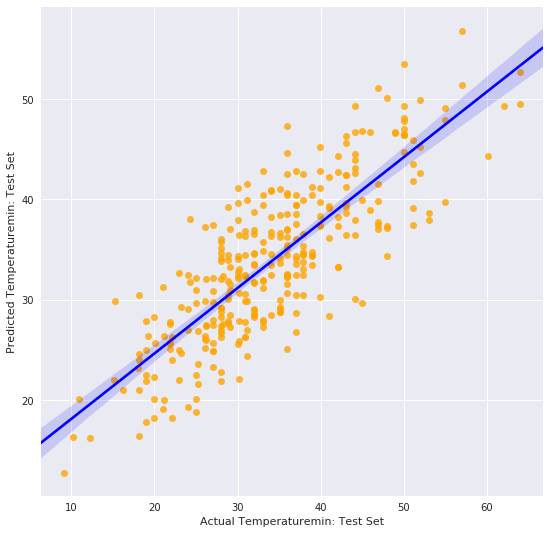

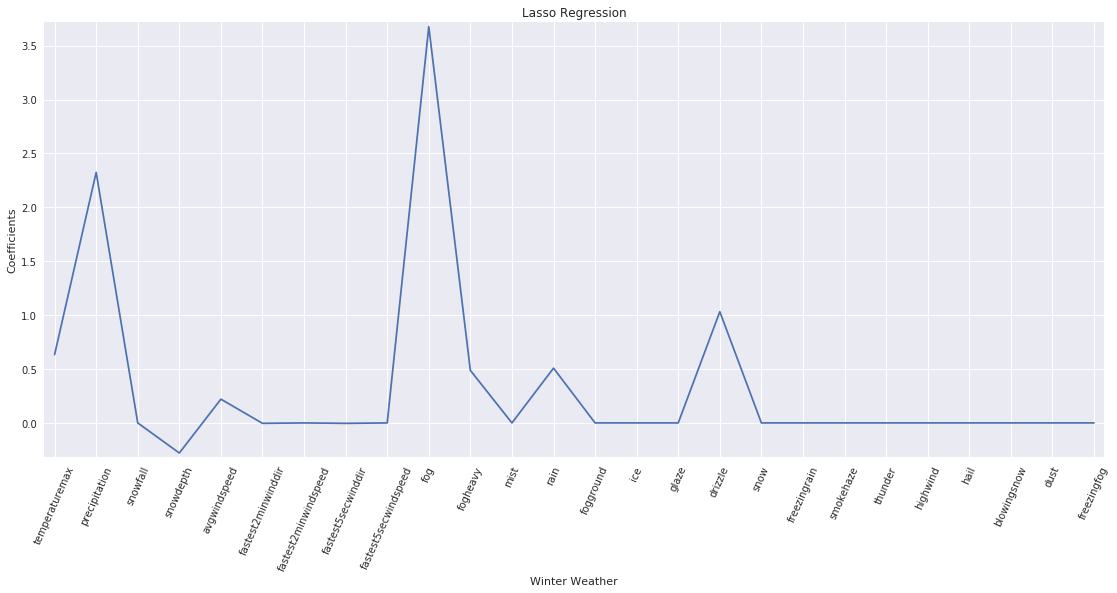

In [9]:
X_winter = winter_weather_history.drop('temperaturemin', axis=1)
X_winter = X_winter.drop('date', axis=1)
X_winter = X_winter.drop('season', axis=1)
X_winter.shape

y_winter = (winter_weather_history['temperaturemin'])
y_winter.shape

# Separando o dataset em treino e teste. 30% para teste, e 70% para treinamento.
X_train, X_test, y_train, y_test = train_test_split(X_winter, y_winter, test_size = 0.3, random_state=42)

lasso = Lasso(alpha=0.015, normalize=True)
lasso.fit(X_train, y_train) 

lasso_coef = lasso.coef_
print("\nCoeficientes:\n", lasso_coef)

print("\nTraining set score: {:.3f}".format(lasso.score(X_train, y_train)))
print("Test set score: {:.3f}".format(lasso.score(X_test, y_test)))
print("Number of features used: {}".format(np.sum(lasso.coef_ != 0)))
print()

predict = lasso.predict(X_test)
#print(predict)

# Gráfico de dispersão das temperaturas mínimas
figure, axes = plt.subplots(figsize=(9, 9))
ax = sns.regplot(x = y_test, y = predict, scatter_kws={"color": "orange"}, line_kws={"color": "blue"})
ax = ax.set(xlabel='Actual Temperaturemin: Test Set', ylabel = 'Predicted Temperaturemin: Test Set')

plt.figure(figsize=(19,8))
plt.plot(range(len(X_winter.columns)),lasso_coef)
plt.xticks(range(len(X_winter.columns)), X_winter.columns, rotation=66)
plt.margins(0.01)

plt.xlabel('Winter Weather')
plt.ylabel('Coefficients')
plt.title('Lasso Regression')
plt.show()

## 3.2. Lasso - Summer Weather Dataset <a name="summer"></a>


Coeficientes:
 [ 0.66797546  0.87755999 -0.         -0.          0.         -0.
 -0.         -0.         -0.          1.25947024  0.          0.
  0.65223544 -0.         -0.          0.          0.         -0.
  0.          0.          0.          0.          0.         -0.
  0.          0.        ]

Training set score: 0.653
Test set score: 0.630
Number of features used: 4



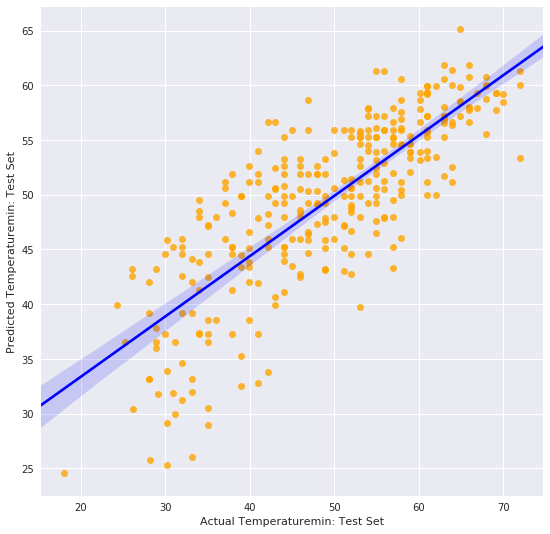

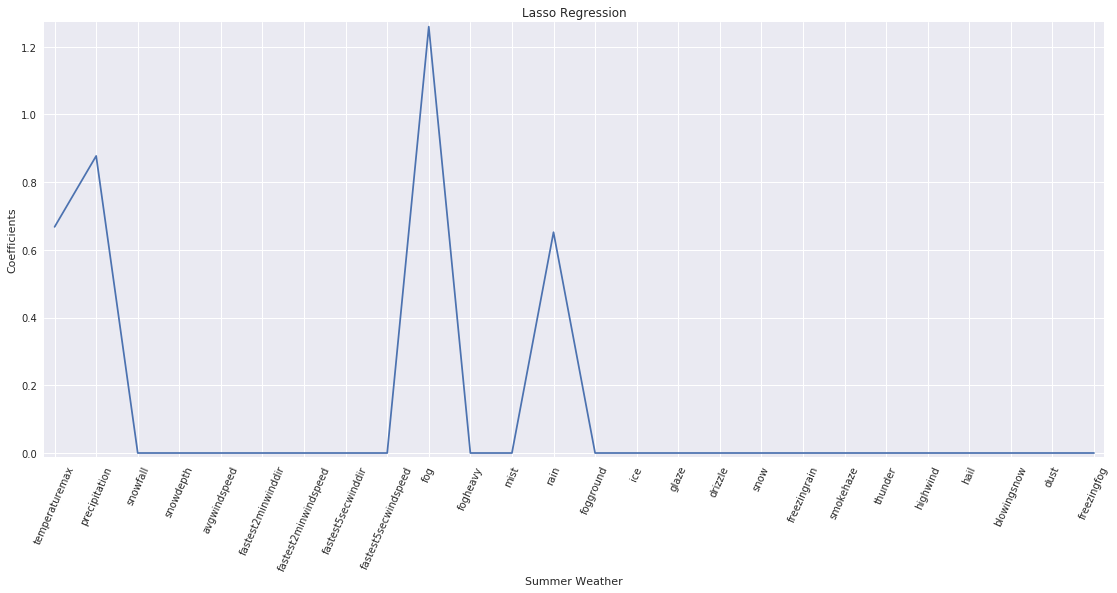

In [11]:
X_summer = summer_weather_history.drop('temperaturemin', axis=1)
X_summer = X_summer.drop('date', axis=1)
X_summer = X_summer.drop('season', axis=1)
X_summer.shape

y_summer = (summer_weather_history['temperaturemin'])
y_summer.shape

X_train, X_test, y_train, y_test = train_test_split(X_summer, y_summer, test_size = 0.3, random_state=42)

lasso = Lasso(alpha=0.05, normalize=True)
lasso.fit(X_train, y_train) 

lasso_coef = lasso.coef_
print("\nCoeficientes:\n", lasso_coef)

print("\nTraining set score: {:.3f}".format(lasso.score(X_train, y_train)))
print("Test set score: {:.3f}".format(lasso.score(X_test, y_test)))
print("Number of features used: {}".format(np.sum(lasso.coef_ != 0)))
print()

predict = lasso.predict(X_test)
#print(predict)

# Gráfico de dispersão das temperaturas mínimas
figure, axes = plt.subplots(figsize=(9, 9))
ax = sns.regplot(x = y_test, y = predict, scatter_kws={"color": "orange"}, line_kws={"color": "blue"})
ax = ax.set(xlabel='Actual Temperaturemin: Test Set', ylabel = 'Predicted Temperaturemin: Test Set')

plt.figure(figsize=(19,8))
plt.plot(range(len(X_summer.columns)),lasso_coef)
plt.xticks(range(len(X_summer.columns)), X_summer.columns, rotation=66)
plt.margins(0.01)

plt.xlabel('Summer Weather')
plt.ylabel('Coefficients')
plt.title('Lasso Regression')
plt.show()

## 3.3. Lasso - Spring Weather Dataset <a name="spring"></a>


Coeficientes:
 [ 0.40737556  0.55664694  0.          0.          0.35726505  0.
 -0.          0.         -0.          0.69654527  0.          0.05654501
  0.         -0.21417357  0.          0.          0.          0.
  0.          0.          0.26119518 -0.          0.29198606 -0.
  0.          0.        ]

Training set score: 0.400
Test set score: 0.356
Number of features used: 8



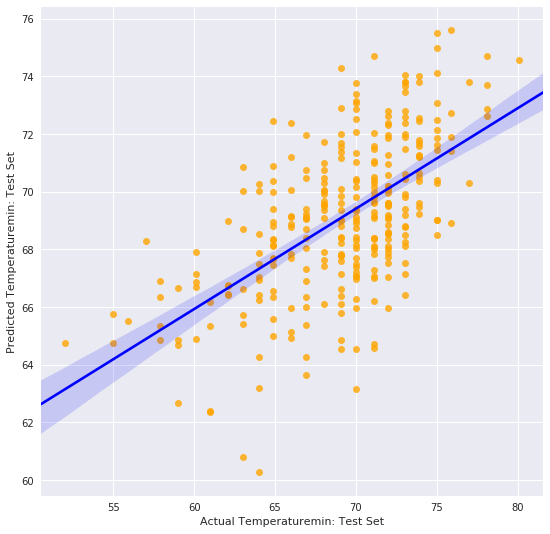

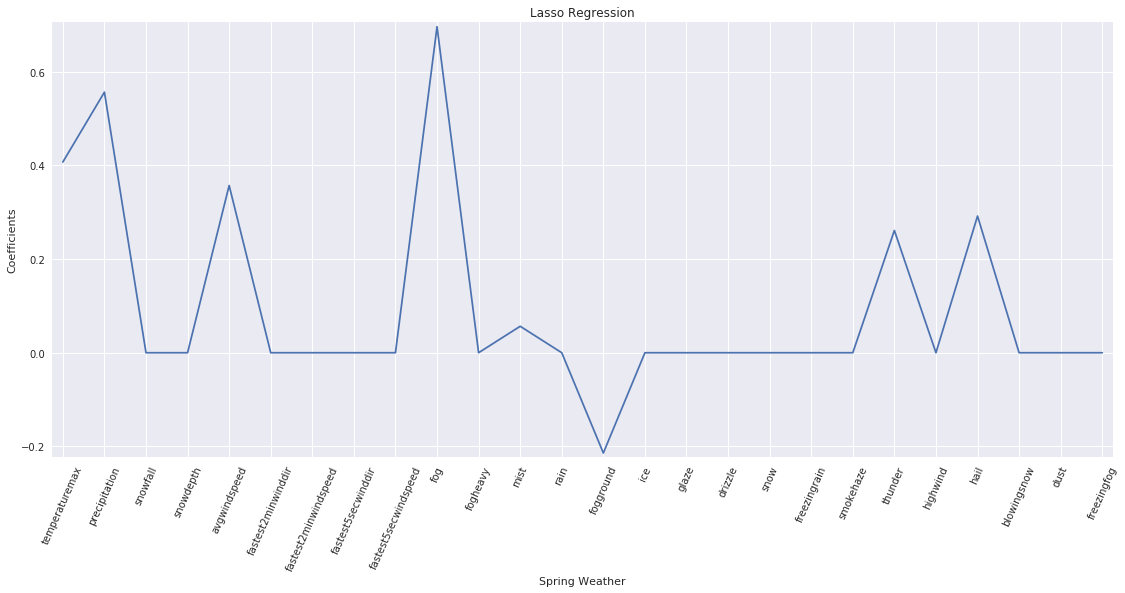

In [12]:
X_spring = spring_weather_history.drop('temperaturemin', axis=1)
X_spring = X_spring.drop('date', axis=1)
X_spring = X_spring.drop('season', axis=1)
X_spring.shape

y_spring = (spring_weather_history['temperaturemin'])
y_spring.shape

X_train, X_test, y_train, y_test = train_test_split(X_spring, y_spring, test_size = 0.3, random_state=42)

lasso = Lasso(alpha=0.01, normalize=True)
lasso.fit(X_train, y_train) 

lasso_coef = lasso.coef_
print("\nCoeficientes:\n", lasso_coef)

print("\nTraining set score: {:.3f}".format(lasso.score(X_train, y_train)))
print("Test set score: {:.3f}".format(lasso.score(X_test, y_test)))
print("Number of features used: {}".format(np.sum(lasso.coef_ != 0)))
print()

predict = lasso.predict(X_test)
#print(predict)

# Gráfico de dispersão das temperaturas mínimas
figure, axes = plt.subplots(figsize=(9, 9))
ax = sns.regplot(x = y_test, y = predict, scatter_kws={"color": "orange"}, line_kws={"color": "blue"})
ax = ax.set(xlabel='Actual Temperaturemin: Test Set', 
ylabel = 'Predicted Temperaturemin: Test Set')

plt.figure(figsize=(19,8))
plt.plot(range(len(X_spring.columns)),lasso_coef)
plt.xticks(range(len(X_spring.columns)), X_spring.columns, rotation=66)
plt.margins(0.01)

plt.xlabel('Spring Weather')
plt.ylabel('Coefficients')
plt.title('Lasso Regression')
plt.show()

## 3.4. Lasso - Autumn Weather Dataset <a name="autumn"></a>


Coeficientes:
 [ 0.82274053  1.05572798 -0.          0.          0.7574394  -0.00811987
 -0.         -0.00231636 -0.          1.93733061  0.          0.
  1.42148259 -0.2244387   0.          0.          0.46616688  0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]

Training set score: 0.767
Test set score: 0.748
Number of features used: 9



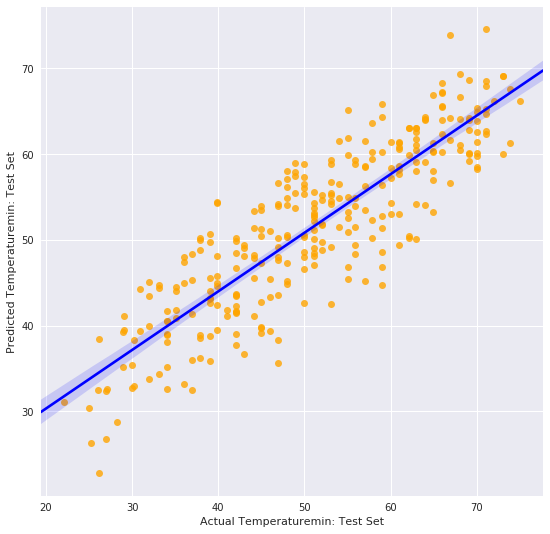

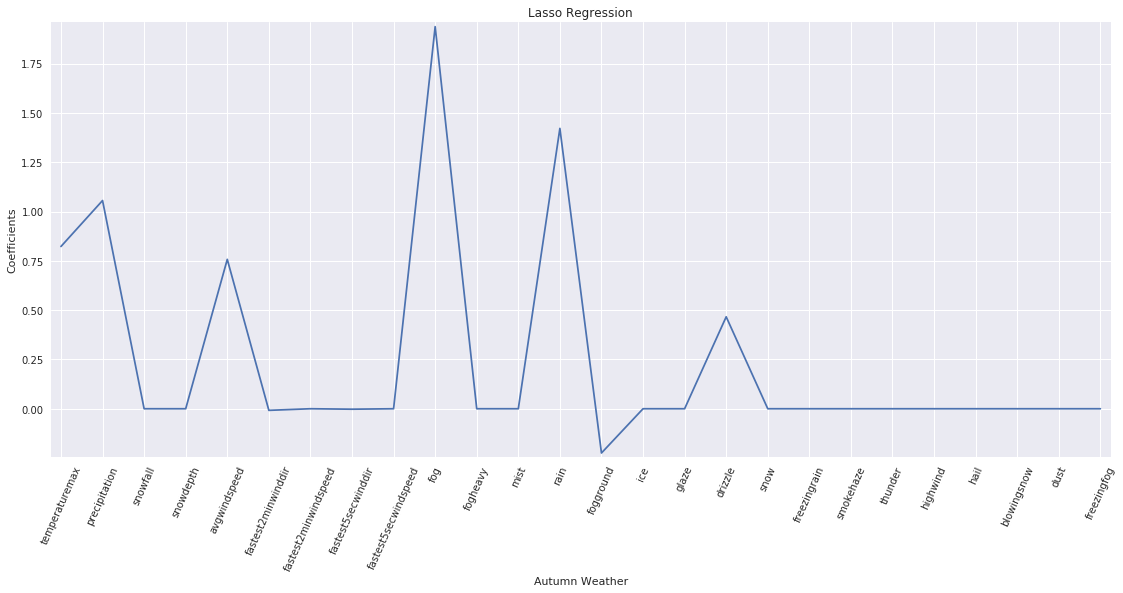

In [13]:
X_autumn = autumn_weather_history.drop('temperaturemin', axis=1)
X_autumn = X_autumn.drop('date', axis=1)
X_autumn = X_autumn.drop('season', axis=1)
X_autumn.shape

y_autumn = (autumn_weather_history['temperaturemin'])
y_autumn.shape

X_train, X_test, y_train, y_test = train_test_split(X_autumn, y_autumn, test_size = 0.3, random_state=42)

lasso = Lasso(alpha=0.03, normalize=True)
lasso.fit(X_train, y_train) 

lasso_coef = lasso.coef_
print("\nCoeficientes:\n", lasso_coef)

print("\nTraining set score: {:.3f}".format(lasso.score(X_train, y_train)))
print("Test set score: {:.3f}".format(lasso.score(X_test, y_test)))
print("Number of features used: {}".format(np.sum(lasso.coef_ != 0)))
print()

predict = lasso.predict(X_test)
#print(predict)

# Gráfico de dispersão das temperaturas mínimas
figure, axes = plt.subplots(figsize=(9, 9))
ax = sns.regplot(x = y_test, y = predict, scatter_kws={"color": "orange"}, line_kws={"color": "blue"})
ax = ax.set(xlabel='Actual Temperaturemin: Test Set', 
ylabel = 'Predicted Temperaturemin: Test Set')

plt.figure(figsize=(19,8))
plt.plot(range(len(X_autumn.columns)),lasso_coef)
plt.xticks(range(len(X_autumn.columns)), X_autumn.columns, rotation=66)
plt.margins(0.01)

plt.xlabel('Autumn Weather')
plt.ylabel('Coefficients')
plt.title('Lasso Regression')
plt.show()

## 4. Métricas para avaliar os resultados previstos<a name="metrics"></a>       

<h4>Definindo métricas:</h4>
<p>De acordo com o quadro abaixo, existem quatro métricas principais para avaliar modelos de regressão.</p>   

![Most Useful Metrics](https://cdn-images-1.medium.com/max/1200/1*8VM2PELQ-oeM0O3ya7BIyQ.png) 


<p style="text-align: justify">Para avaliar os erros resultados previstos pelo algoritmo, serão utilizadas duas métricas:</p>    

<ul>
  <li><b>Mean Absolute Error</b> - Média dos erros em valores absolutos.</li>
  <li><b>Root Mean Squared Error</b>  - Fornece uma indicação da adequação de um conjunto de previsões aos valores reais. Mais conhecida como coeficiente de determinação.</li>
</ul>   

<p style="text-align: justify"><b>OBS: Por existirem vários <i>datasets</i>, e para o notebook não ficar demasiadamente extenso, apenas um (<i>"autumn"</i>), terá suas métricas exibidas. O procedimento é o mesmo para todos os datasets.</b></p>

### 4.1 Mean Absolute Error (MAE)<a name="mae"></a>        

<p style="text-align: justify">O Erro Absoluto Médio (ou MAE) é a soma das diferenças absolutas entre previsões e valores reais. Dá uma ideia de quão erradas estão as previsões.
A medida dá uma ideia da magnitude do erro, mas não da direção (por exemplo, <i>over</i> ou <i>under predicting</i>).</p>
<p style="text-align: justify"> A MAE quando 0, indica ausência de erro, ou previsões perfeitas.</p>

In [14]:
from sklearn.metrics import mean_absolute_error

print("MAE: {:.3f}".format(mean_absolute_error(y_test, predict)))

MAE: 5.130


### 4.2 Root Mean Squared Error<a name="rmse"></a>        
<p style="text-align: justify">O RMSE é calculado como a raiz quadrada da média das diferenças quadráticas entre os resultados reais e as previsões.

A quadratura de cada erro força os valores a serem positivos e a raiz quadrada do erro quadrático médio retorna a métrica de erro às unidades originais para comparação.
<p style="text-align: justify">Os valores do RMSE são sempre um pouco mais altos do que os valores do MSE, que se tornam mais pronunciados à medida que os erros de previsão aumentam. O RMSE de zero indica nenhum erro.</p>

In [15]:
from sklearn.metrics import mean_squared_error
train_RMSE = np.sqrt(mean_squared_error(y_train, lasso.predict(X_train)))
test_RMSE = np.sqrt(mean_squared_error(y_test, lasso.predict(X_test)))
print('Training RMSE: {:.3f}'.format(train_RMSE))
print('Test RMSE: {:.3f}'.format(test_RMSE))

Training RMSE: 6.239
Test RMSE: 6.296


## 5. Referências <a name="references"></a>    

> [Coeficiente de correlação de Pearson](https://pt.wikipedia.org/wiki/Coeficiente_de_correla%C3%A7%C3%A3o_de_Pearson#Refer%C3%AAncias)

> [A comprehensive beginners guide for Linear, Ridge and Lasso Regression](https://www.analyticsvidhya.com/blog/2017/06/a-comprehensive-guide-for-linear-ridge-and-lasso-regression/)

> [Choosing the Right Metric for Evaluating ML Models](https://towardsdatascience.com/choosing-the-right-metric-for-machine-learning-models-part-1-a99d7d7414e4)